# Перемешиваем модальности

# Metadata
transforms, model+optimizer+loss, hyperparams

In [1]:
TITLE = "ft int+flip, contextnet-SegResNetDS+adan+dicefocal"

# Imports

In [2]:
from glio.imports import *
from glio.importsglio import *

from glio.datasets.mri_preloaded import *
from glio.specific.mri_around import *
from glio.specific.vkr2 import *
from glio.transforms.intensity import RandScale, RandShift
from glio.transforms.spatial import RandFlipt

from glio.torch_tools import ConcatZeroChannelsToDataloader, BatchInputTransforms

d:\miniconda3\envs\pytorch311\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Dataset

In [3]:
rhuhtrain = get_ds_around(RHUH_TRAIN)
rhuhtest = get_ds_around(RHUH_TEST)

In [3]:
from monai import transforms as mtf

# fast tfms
gaussianblur = mtf.RandGaussianSmooth(prob=0.1) # type:ignore
contrast = mtf.RandAdjustContrast(gamma = (0.5, 2), prob=0.1) # type:ignore

# slower tfms
biasfield = mtf.RandBiasField(prob=0.1) # type:ignore
hist_shift = mtf.RandHistogramShift(prob=0.05) # type:ignore
gibbs = mtf.RandGibbsNoise(prob=0.1) # type:ignore
riccan = mtf.RandRicianNoise(std=0.5, prob=0.05) # type:ignore

# very slow
kspike = mtf.RandKSpaceSpikeNoise(prob=0.1) # type:ignore

def rand_shuffle_channels_around(x:torch.Tensor, channels_per = 3):
    if random.random() < 0.1:
        num_groups = int(x.shape[0] / channels_per)
        perm = torch.randperm(num_groups, dtype=torch.int32)
        img= x.reshape(num_groups, channels_per, *x.shape[1:])[perm].flatten(0, 1)
        return img
    return x

def rand_group_dropout(x):
    if random.random() < 0.08: return torch.zeros_like(x)
    if random.random() < 0.02: return torch.randn_like(x)
    return x

def randnoise(x):
    if random.random() < 0.1: return x + torch.randn_like(x) * random.triangular(0, 0.5, 0)
    return x


In [5]:
dstrain = DSToTarget(0)
dstest = DSToTarget(0)

dstrain.add_samples(rhuhtrain, loader_around_seq_fix, RandFlipt(p=0.5), [get0, rand_shuffle_channels_around, GroupwiseTfms((randnoise, RandScale((0.75, 1.5), p=0.3), RandShift((-0.5, 0.5), p=0.3), rand_group_dropout))], get1)
dstest.add_samples(rhuhtest, loader_around_seq, randcrop, get0, get1)
print(len(dstrain))
print(len(dstest))

20794
2412


# Performance

In [6]:
x = torch.randn((3,96,96))
with perf_counter_context():
    for i in range(100):
        dstrain[i]

Context took 0.7029693000004045 perf_counter seconds


# Inputs / targets preview

(<Figure size 2400x2400 with 4 Axes>,
 array([[<Axes: title={'center': 'inputs'}>,
         <Axes: title={'center': 'targets'}>],
        [<Axes: title={'center': 'inputs - test'}>,
         <Axes: title={'center': 'targets - test'}>]], dtype=object))

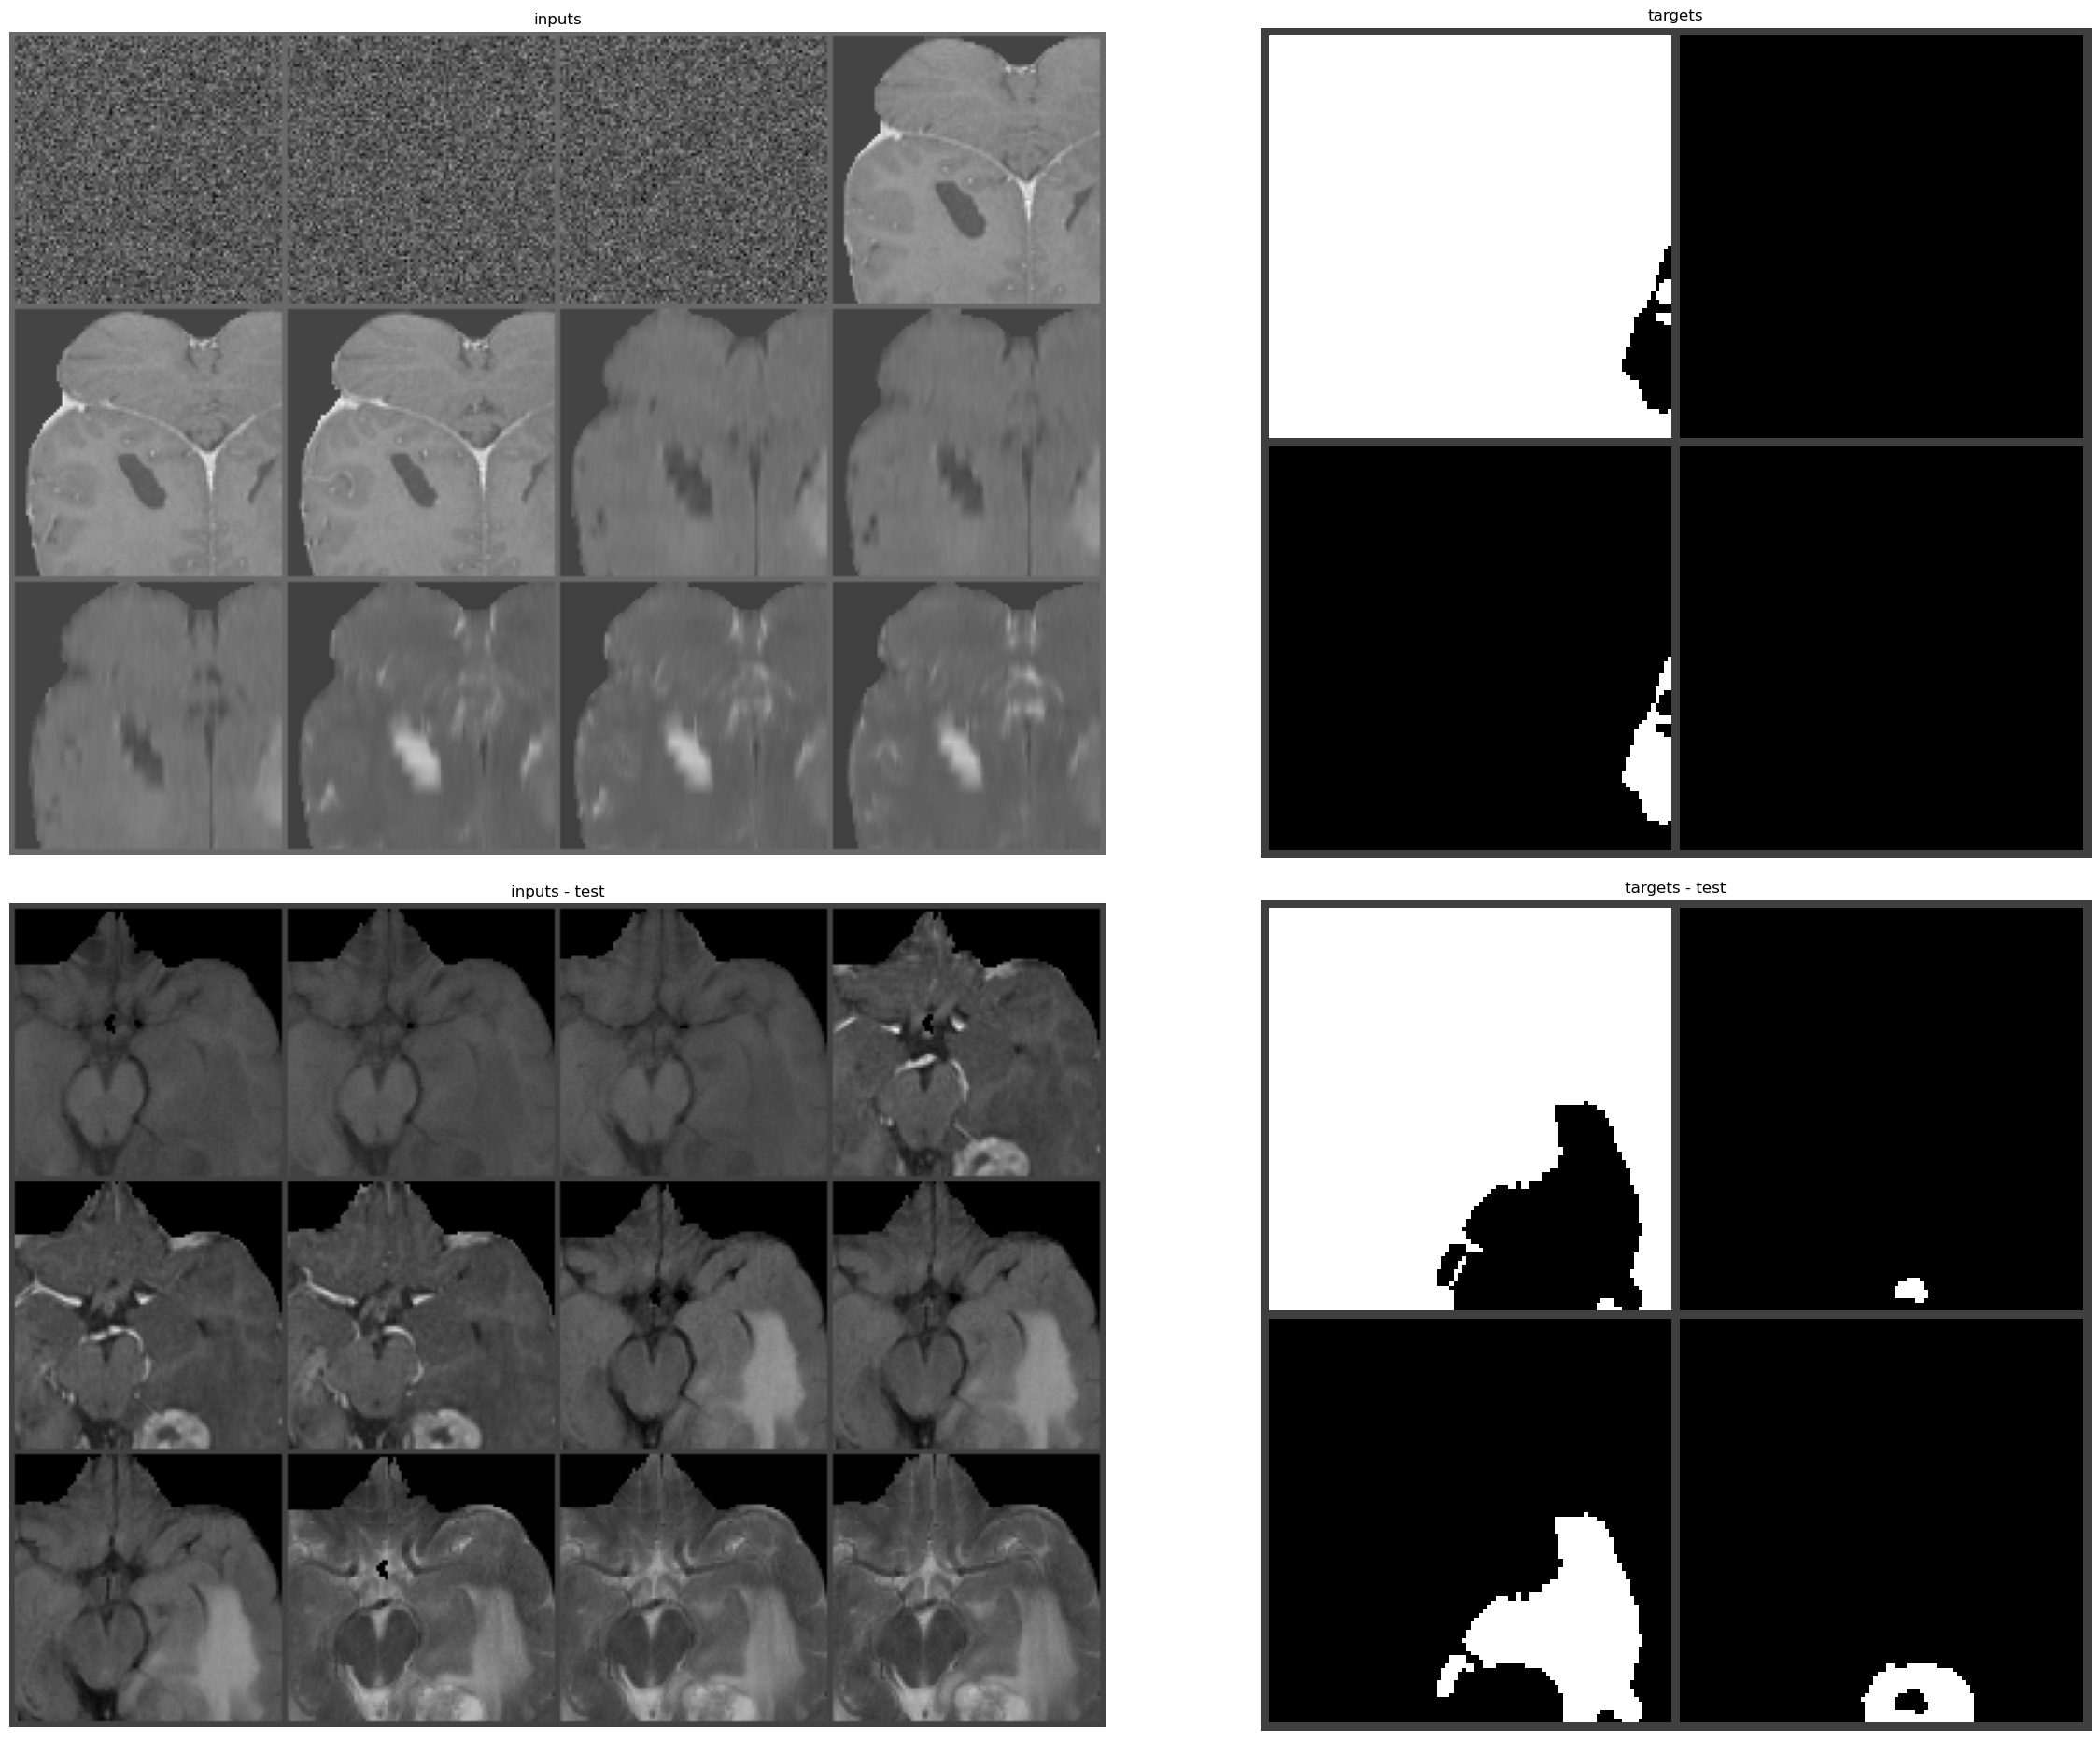

In [7]:
fig = Figure()
sample_ = dstrain[300]
fig.add().imshow_batch(sample_[0]).style_img('inputs')
fig.add().imshow_batch(sample_[1]).style_img('targets')
sample_ = dstest[20]
fig.add().imshow_batch(sample_[0]).style_img('inputs - test')
fig.add().imshow_batch(sample_[1]).style_img('targets - test')
fig.create(2, figsize=(24,24))

# Model

In [4]:
from monai.networks.nets import HighResNet, SegResNetDS # type:ignore
def HighResNet_noReLUattheend(in_channels=12, out_channels=20):
    model = HighResNet(2, in_channels, out_channels)
    model.blocks[-1].adn = nn.Identity()
    return model

single_tfms = Compose(rand_shuffle_channels_around, GroupwiseTfms((randnoise, RandScale(p=0.3, val=(0.75, 1.5)), RandShift(p=0.3, val=(-0.3, 0.3)), rand_group_dropout)))
batch_tfms = torch.vmap(single_tfms, randomness='different')

mse = torch.nn.MSELoss()

class ContextHRN(nn.Module):
    def __init__(self, pretraining = False):
        super().__init__()
        self.pretraining = pretraining
        self.batch_tfms = batch_tfms
        self.hrn = HighResNet_noReLUattheend(12, 20)

    def forward(self, x:torch.Tensor):
        if self.training and self.pretraining:
            with torch.no_grad(): self.tfmed = self.batch_tfms(x)
            self.processed = self.hrn(self.tfmed)
            loss = mse(self.processed[:, :12], x)
            return self.processed[:,12:16], loss
        elif self.pretraining: 
            self.processed = self.hrn(x)
            return self.processed[:,12:16]
        else:
            self.processed = self.hrn(x)
            return self.processed
        
class ContextSegResNetDS_FineTune(nn.Module):
    def __init__(self):
        super().__init__()
        self.context_block = ContextHRN(False)
        self.net = SegResNetDS(2, 32, 32, 4)
    def forward(self, x:torch.Tensor):
        self.context = self.context_block(x)
        return self.net(torch.cat((x, self.context), 1))
print(f"{count_parameters(ContextSegResNetDS_FineTune()) = }")

count_parameters(ContextSegResNetDS_FineTune()) = 6928676


# Train

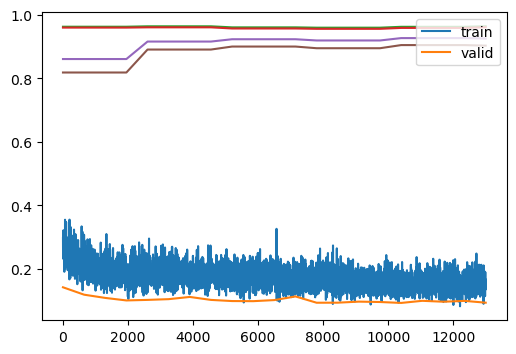

test loss: min: 0.0935; max: 0.1427; last: 0.0943                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [13]:
from stuff.found.torch.optim.Adan import Adan
from monai.losses import DiceFocalLoss # type:ignore

MODEL = ContextSegResNetDS_FineTune()
MODEL.load_state_dict(torch.load(r"F:\Stuff\Programming\experiments\vkr\training\BRATS v2 full + RHUH v2 full, 32\models\int+flip, contextnet-SegResNetDS+adan+dicefocal - BRATS\8 - testloss=0.19132; testacc=0.98592)\model.pt"))
NAME = f"{MODEL.__class__.__name__}"
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 20

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = DataLoader(dstrain, BATCH_SIZE, shuffle=True)
dltest = DataLoader(dstest, BATCH_SIZE)

OPT = Adan(MODEL.parameters(), lr=LR)
LOSS_FN = DiceFocalLoss(softmax=True)
SCHED = lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dltrain), epochs=N_EPOCHS)

clean_mem()
# MODEL = gnn.LSUV(MODEL, dltrain, max_iter=10)

CALLBACKS =  (Metric_Loss(),
              Log_Time(), Save_Best(), Save_Last(), Log_LR(), PerformanceTweaks(True), Accelerate("no"),
              MONAI_IoU(4, True, True, step=32, name='iou'),
              Torcheval_AURPC(4, True, step=32),
              Torcheval_AUROC(4, True, step=32),
              MONAI_ConfusionMatrix(step=4), MONAI_ConfusionMatrixMetrics(),
              MONAI_ConfusionMatrix(step=4, include_bg = False, name="nobg confusion matrix"), MONAI_ConfusionMatrixMetrics(key = 'nobg confusion matrix', prefix='nobg '),
              FastProgressBar(step_batch=128, plot=True, metrics=('train loss', 'test loss', 
                                                                  'test balanced accuracy', 'test nobg balanced accuracy',
                                                                  'test f1 score', 'test nobg f1 score'), maxv=1),
              Summary(),
              PlotSummary(path='summaries'),
              PrintLoss(),
              SaveReferenceVisualizationsAfterEachEpoch('reference preds'),
              #Metric_PredsTargetsFn(LOSS_FN, name='dice loss'),
              #CallTrainAndEvalOnOptimizer(),
              #AddLossReturnedByModelToLossInBackward(),
            )
LEARNER_NAME = f"{TITLE} lr{LR:.0e} OneCycleLR"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = CALLBACKS,
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest, test_first=True, test_on_interrupt=False)
plt.show()


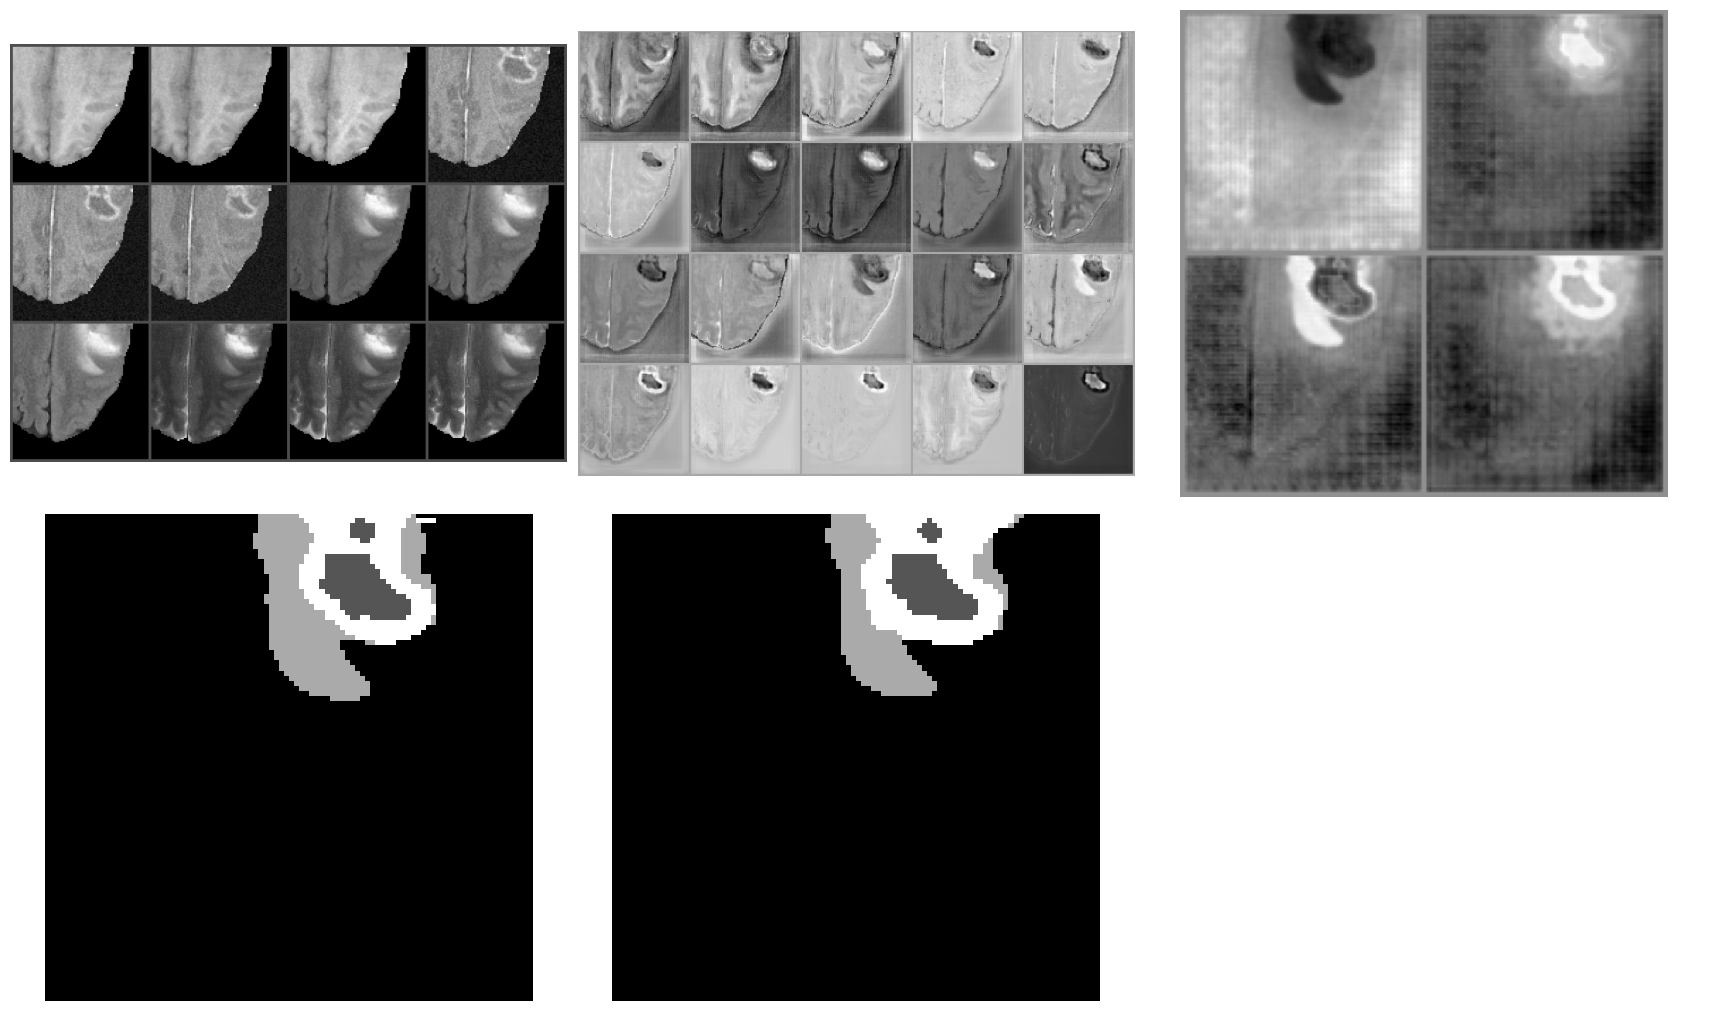

In [32]:
inputs, targets = dstrain[18000]
inputs = inputs.unsqueeze(0)
f = Figure()
preds = learner.inference(inputs)
f.add().imshow_batch(inputs[0], maxelems=100, scale_each=True).style_img()
f.add().imshow_batch(learner.model.context[0], maxelems=100, scale_each=True).style_img()
f.add().imshow_batch(preds[0], maxelems=100, scale_each=True).style_img()
f.add().imshow(preds[0].argmax(0), vmin=0, vmax=3).style_img()
f.add().imshow(targets.argmax(0), vmin=0, vmax=3).style_img()
f.show(figsize=(17,17), nrow=2)

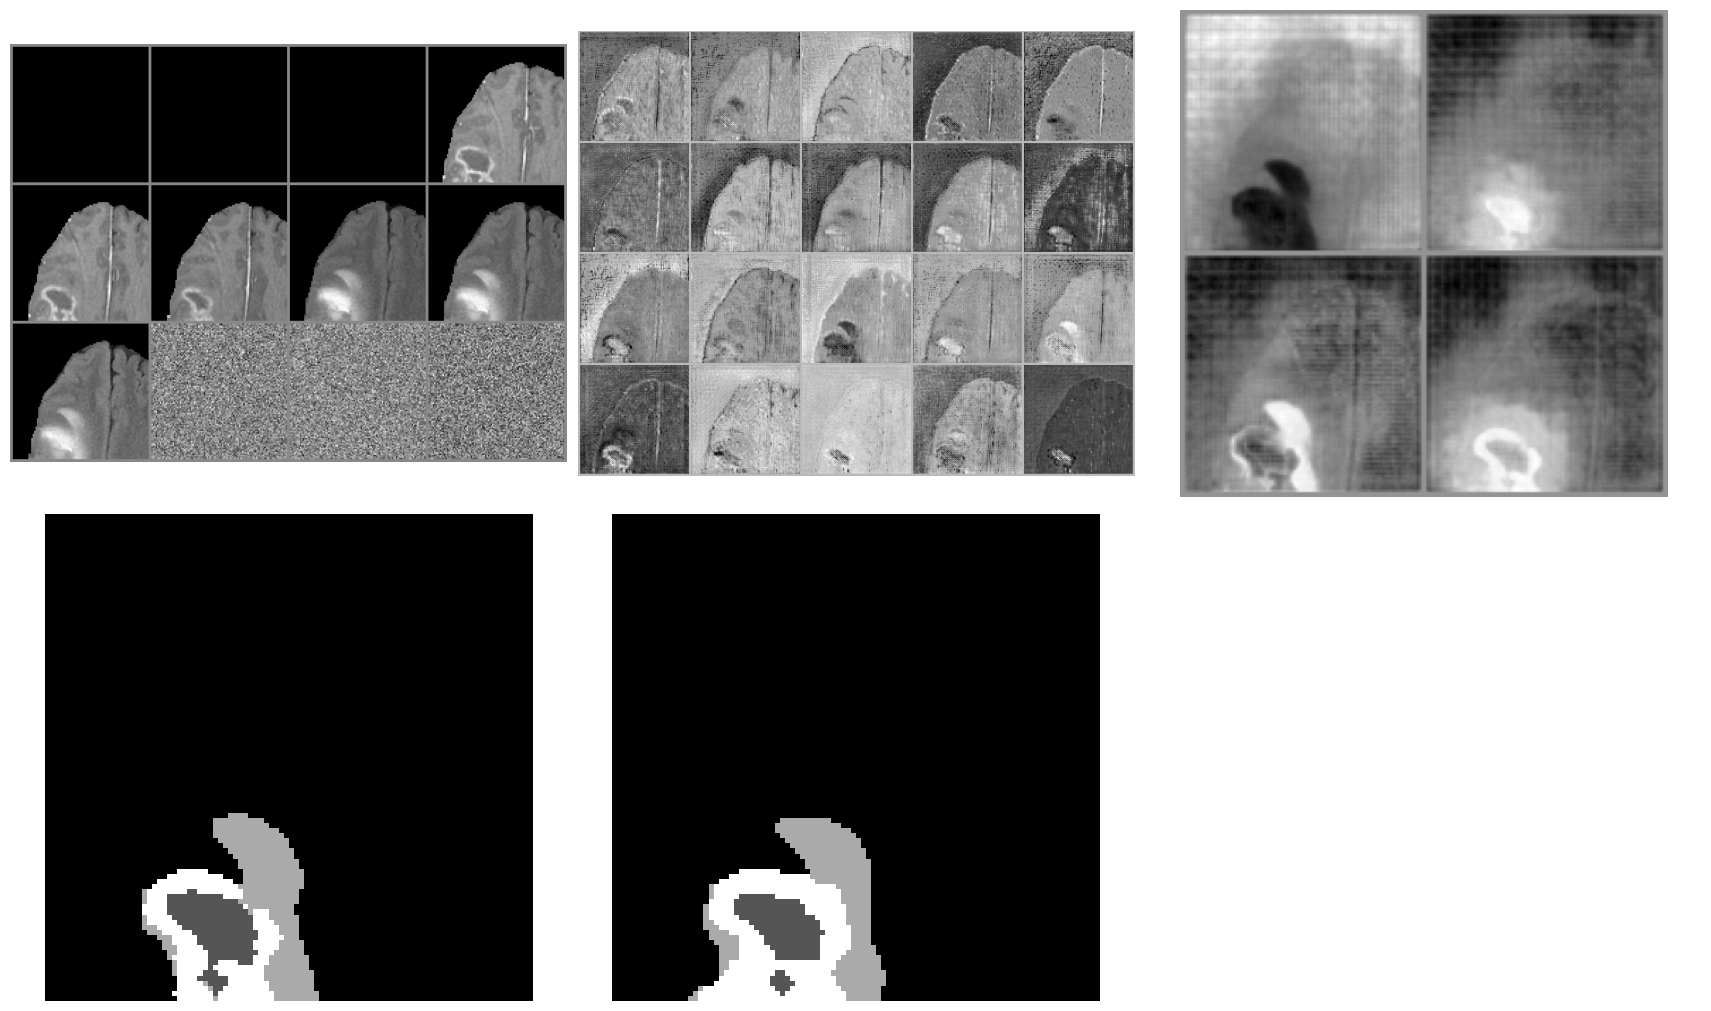

In [41]:
inputs, targets = dstrain[18000]
inputs = inputs.unsqueeze(0)
f = Figure()
preds = learner.inference(inputs)
f.add().imshow_batch(inputs[0], maxelems=100, scale_each=True).style_img()
f.add().imshow_batch(learner.model.context[0], maxelems=100, scale_each=True).style_img()
f.add().imshow_batch(preds[0], maxelems=100, scale_each=True).style_img()
f.add().imshow(preds[0].argmax(0), vmin=0, vmax=3).style_img()
f.add().imshow(targets.argmax(0), vmin=0, vmax=3).style_img()
f.show(figsize=(17,17), nrow=2)

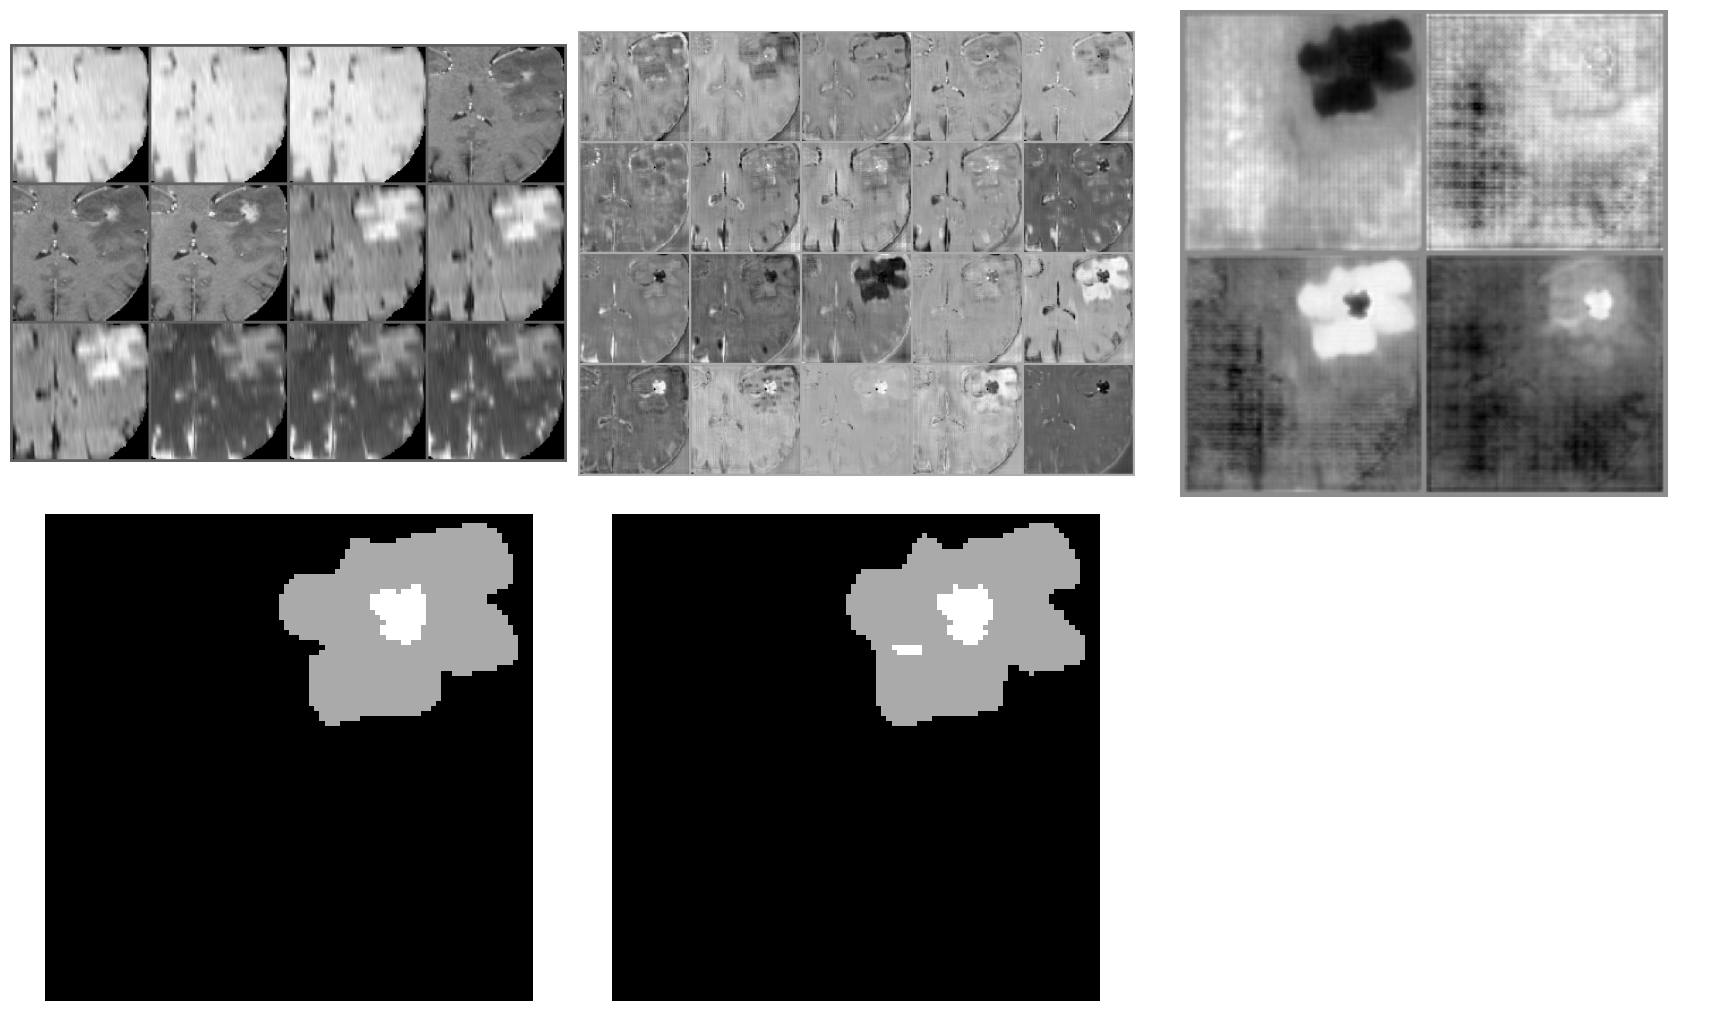

In [59]:
inputs, targets = dstest[400]
inputs = inputs.unsqueeze(0)
f = Figure()
preds = learner.inference(inputs)
f.add().imshow_batch(inputs[0], maxelems=100, scale_each=True).style_img()
f.add().imshow_batch(learner.model.context[0], maxelems=100, scale_each=True).style_img()
f.add().imshow_batch(preds[0], maxelems=100, scale_each=True).style_img()
f.add().imshow(preds[0].argmax(0), vmin=0, vmax=3).style_img()
f.add().imshow(targets.argmax(0), vmin=0, vmax=3).style_img()
f.show(figsize=(17,17), nrow=2)

In [8]:
from glio.mri.pipeline import Pipeline
from glio.specific.vkr2 import sliding_inference_around_tta

MODEL = ContextSegResNetDS_FineTune().to(torch.device("cuda"))
sd = r"F:\Stuff\Programming\experiments\vkr\training\RHUH v2 full + BRATS v2 test, 32\checkpoints\ft int+flip, contextnet-SegResNetDS+adan+dicefocal lr1e-03 OneCycleLR\1. 03.06.2024 13-35-17 (20-13000; testloss=0.09427; testacc=0.99227)\model.pt"
MODEL.load_state_dict(torch.load(sd))
l = Learner(MODEL, '', ())

t1 = r"D:\vkr\new\dcm organized by date\5\22 jun 2015\[5] MR Ax 3DT1 SPGR S -- 120 _"
t1ce = r"D:\vkr\new\dcm organized by date\5\22 jun 2015\[7] MR Ax 3DT1 SPGR S+C -- 12_"
flair = r"D:\vkr\new\dcm organized by date\5\22 jun 2015\[4] MR O-Ax Flair irFSE S -- _"
t2w = r"D:\vkr\new\dcm organized by date\5\22 jun 2015\[3] MR AX T2 FRFSE -- 27 inst_"

import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

p = Pipeline(t1=t1, t1ce=t1ce, flair=flair, t2w=t2w, )
inputs = p.preprocess()
preds = sliding_inference_around_tta(inputs, l.inference, size=(96,96))
show_slices(preds)

INFO:root:Регистрация модальностей в SRI24
INFO:root:Удаление черепа


File: C:\Users\nkshv\AppData\Local\Temp\tmpcxxjjian\t1.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...


INFO:root:Нормализация
100%|██████████| 25/25 [00:04<00:00,  5.66it/s]


interactive(children=(Checkbox(value=False, description='color'), IntSlider(value=1, description='s0', max=3),…

<function glio.jupyter_tools.show_slices.<locals>.f(color, **kwargs)>

In [7]:
show_slices(inputs)

interactive(children=(Checkbox(value=False, description='color'), IntSlider(value=1, description='s0', max=3),…

<function glio.jupyter_tools.show_slices.<locals>.f(color, **kwargs)>

In [8]:
inputs.shape

torch.Size([4, 133, 165, 127])

In [10]:
save_seg_visualization(t1n = inputs[0], t1c=inputs[1], t2f=inputs[2], t2w = inputs[3], seg=preds.argmax(0), outfolder='preview')

In [5]:
from glio.mri.pipeline import Pipeline
from glio.specific.vkr2 import sliding_inference_around_tta

MODEL = ContextSegResNetDS_FineTune().to(torch.device("cuda"))
sd = r"F:\Stuff\Programming\experiments\vkr\training\RHUH v2 full + BRATS v2 test, 32\checkpoints\ft int+flip, contextnet-SegResNetDS+adan+dicefocal lr1e-03 OneCycleLR\1. 03.06.2024 13-35-17 (20-13000; testloss=0.09427; testacc=0.99227)\model.pt"
MODEL.load_state_dict(torch.load(sd))
l = Learner(MODEL, '', ())

t1 = r"D:\vkr\new\nii\5\1\preop\wdir\tmpj4uve0of\nii_final\[5] MR Ax 3DT1 SPGR S -- 120 _.nii.gz"
t1ce = r"D:\vkr\new\nii\5\1\preop\wdir\tmpj4uve0of\nii_final\[7] MR Ax 3DT1 SPGR S+C -- 12_.nii.gz"
flair = r"D:\vkr\new\nii\5\1\preop\wdir\tmpj4uve0of\nii_final\[4] MR O-Ax Flair irFSE S -- _.nii.gz"
t2w = r"D:\vkr\new\nii\5\1\preop\wdir\tmpj4uve0of\nii_final\[3] MR AX T2 FRFSE -- 27 inst_.nii.gz"

import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [6]:
p = Pipeline(t1=t1, t1ce=t1ce, flair=flair, t2w=t2w, register=False, skullstrip=False, erode=0)
inputs = p.preprocess()
preds = sliding_inference_around_tta(inputs, l.inference, size=(96,96))

INFO:root:Регистрация модальностей в SRI24
INFO:root:Удаление черепа
INFO:root:Нормализация
100%|██████████| 25/25 [00:04<00:00,  5.31it/s]


In [5]:

show_slices(preds)
save_seg_visualization(t1n = inputs[0], t1c=inputs[1], t2f=inputs[2], t2w = inputs[3], seg=preds.argmax(0), outfolder='preview2')

INFO:root:Регистрация модальностей в SRI24
INFO:root:Удаление черепа
INFO:root:Нормализация
100%|██████████| 25/25 [00:04<00:00,  5.56it/s]


interactive(children=(Checkbox(value=False, description='color'), IntSlider(value=1, description='s0', max=3),…

In [7]:
import SimpleITK as sitk
from glio.mri.registration import register_with
from glio.mri.dicom_to_nifti import dicom2sitk
segitk = sitk.GetImageFromArray(preds.argmax(0))
segitk.CopyInformation(p.t1ce_processed)
native = dicom2sitk(r'D:\vkr\new\dcm organized by date\5\22 jun 2015\[7] MR Ax 3DT1 SPGR S+C -- 12_')
_, seg_native = register_with(p.t1ce_processed, segitk, native)

show_slices((sitk.GetArrayFromImage(native), sitk.GetArrayFromImage(seg_native)))

interactive(children=(Checkbox(value=False, description='color'), IntSlider(value=0, description='s0', max=1),…

<function glio.jupyter_tools.show_slices.<locals>.f(color, **kwargs)>

In [20]:
sitk.GetArrayFromImage(seg_native).max()

4.2781277

In [9]:
from glio.mri.pipeline import Pipeline
from glio.specific.vkr2 import sliding_inference_around_tta
t1 = r"D:\vkr\new\dcm organized by date\5\22 jun 2015\[5] MR Ax 3DT1 SPGR S -- 120 _"
t1ce = r"D:\vkr\new\dcm organized by date\5\22 jun 2015\[7] MR Ax 3DT1 SPGR S+C -- 12_"
flair = r"D:\vkr\new\dcm organized by date\5\22 jun 2015\[4] MR O-Ax Flair irFSE S -- _"
t2w = r"D:\vkr\new\dcm organized by date\5\22 jun 2015\[3] MR AX T2 FRFSE -- 27 inst_"
p = Pipeline(t1=t1, t1ce=t1ce, flair=flair, t2w=t2w, )
inputs = p.preprocess()
for checkpoint in os.listdir(r'F:\Stuff\Programming\experiments\vkr\training\RHUH v2 full + BRATS v2 test, 32\checkpoints\ft int+flip, contextnet-SegResNetDS+adan+dicefocal lr1e-03 OneCycleLR'):

    MODEL = ContextSegResNetDS_FineTune().to(torch.device("cuda"))
    sd = rf"F:\Stuff\Programming\experiments\vkr\training\RHUH v2 full + BRATS v2 test, 32\checkpoints\ft int+flip, contextnet-SegResNetDS+adan+dicefocal lr1e-03 OneCycleLR\{checkpoint}\model.pt"
    MODEL.load_state_dict(torch.load(sd))
    l = Learner(MODEL, '', ())

    import logging
    logging.basicConfig()
    logging.getLogger().setLevel(logging.INFO)

    preds = sliding_inference_around_tta(inputs, l.inference, size=(96,96))
    os.mkdir(f'previews/{checkpoint}')
    save_seg_visualization(t1n = inputs[0], t1c=inputs[1], t2f=inputs[2], t2w = inputs[3], seg=preds.argmax(0), outfolder=f'previews/{checkpoint}')

INFO:root:Регистрация модальностей в SRI24
INFO:root:Удаление черепа


File: C:\Users\nkshv\AppData\Local\Temp\tmpc7o6r5lk\t1.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...


INFO:root:Нормализация
100%|██████████| 25/25 [00:04<00:00,  5.36it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'F:\\Stuff\\Programming\\experiments\\vkr\\training\\RHUH v2 full + BRATS v2 test, 32\\checkpoints\\ft int+flip, contextnet-SegResNetDS+adan+dicefocal lr1e-03 OneCycleLR\\logger.npz\\model.pt'